In [82]:
import os
from scapy.all import rdpcap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [162]:
# Path to the folder containing the CSV files
DATA_FOLDER = "MachineLearningCVE"

# Function to load all CSV files and combine into a single DataFrame
def load_csv_files(data_folder):
    csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
    dataframes = []
    for csv_file in csv_files:
        file_path = os.path.join(data_folder, csv_file)
        print(f"Loading {file_path}...")
        df = pd.read_csv(file_path)
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

# Load the data
data = load_csv_files(DATA_FOLDER)

Loading MachineLearningCVE\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
Loading MachineLearningCVE\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
Loading MachineLearningCVE\Friday-WorkingHours-Morning.pcap_ISCX.csv...
Loading MachineLearningCVE\Monday-WorkingHours.pcap_ISCX.csv...
Loading MachineLearningCVE\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
Loading MachineLearningCVE\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
Loading MachineLearningCVE\Tuesday-WorkingHours.pcap_ISCX.csv...
Loading MachineLearningCVE\Wednesday-workingHours.pcap_ISCX.csv...


In [4]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [152]:
data.columns = data.columns.str.strip() 
data.Label.value_counts()

Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [153]:
data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [163]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

data.columns = data.columns.str.strip()
data = data.query("Label != 'Heartbleed' & Label != 'Infiltration'")

# Ratio-Based Features
data['Fwd to Bwd Packet Ratio'] = data['Total Fwd Packets'] / (data['Total Backward Packets'] + 1e-9)
data['Bwd to Fwd Packet Ratio'] = data['Total Backward Packets'] / (data['Total Fwd Packets'] + 1e-9)
data['Fwd to Bwd Length Ratio'] = data['Total Length of Fwd Packets'] / (data['Total Length of Bwd Packets'] + 1e-9)
data['Bwd to Fwd Length Ratio'] = data['Total Length of Bwd Packets'] / (data['Total Length of Fwd Packets'] + 1e-9)

# Statistical Features
data['Total Packet Length'] = data['Total Length of Fwd Packets'] + data['Total Length of Bwd Packets']
data['Total Packet Count'] = data['Total Fwd Packets'] + data['Total Backward Packets']
data['Flow IAT Range'] = data['Flow IAT Max'] - data['Flow IAT Min']

# Flag Ratios
data['FIN Ratio'] = data['FIN Flag Count'] / (data['Total Packet Count'] + 1e-9)
data['SYN Ratio'] = data['SYN Flag Count'] / (data['Total Packet Count'] + 1e-9)
data['ACK Ratio'] = data['ACK Flag Count'] / (data['Total Packet Count'] + 1e-9)
data['PSH Ratio'] = data['PSH Flag Count'] / (data['Total Packet Count'] + 1e-9)
data['URG Ratio'] = data['URG Flag Count'] / (data['Total Packet Count'] + 1e-9)

# Time-Based Features
data['Idle Time Range'] = data['Idle Max'] - data['Idle Min']
data['Active Time Range'] = data['Active Max'] - data['Active Min']
data['IAT Range'] = data['Flow IAT Max'] - data['Flow IAT Min']
data['Activity-to-Idle Ratio'] = (data['Active Max'] + data['Active Min']) / (data['Idle Max'] + data['Idle Min'] + 1e-9)

# Flow Characteristics
data['Packets Per Flow'] = data['Total Packet Count'] / (data['Flow Duration'] + 1e-9)
data['Flow Header to Length Ratio'] = (data['Fwd Header Length'] + data['Bwd Header Length']) / (data['Total Packet Length'] + 1e-9)

# Interaction Features
data['Flow Intensity'] = data['Flow Bytes/s'] * data['Flow Packets/s']
data['Packet Size Intensity'] = data['Avg Fwd Segment Size'] * data['Avg Bwd Segment Size']
data['Avg Packet Length'] = (data['Total Length of Fwd Packets'] + data['Total Length of Bwd Packets']) / data['Total Packet Count']
data['Header to Packet Length Ratio'] = (data['Fwd Header Length'] + data['Bwd Header Length']) / data['Total Packet Length']
data['Flow Intensity'] = data['Flow Bytes/s'] * data['Flow Packets/s']


# Remove any rows with NaN or infinite values after feature engineering
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)


# Separate the BENIGN class (label: 0) and other classes
benign_data = data[data['Label'] == 'BENIGN']
non_benign_data = data[data['Label'] != 'BENIGN']

# Downsample the BENIGN class
benign_downsampled = resample(
    benign_data,
    replace=False,  # Sample without replacement
    n_samples=int(len(benign_data) * 0.25),  # Keep 25% of BENIGN samples
    random_state=42
)

# Combine downsampled BENIGN class with other classes
data_balanced = pd.concat([benign_downsampled, non_benign_data], axis=0)

# Extract features and labels
X = data_balanced.drop(columns=['Label'])  # Features
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)  # Replace NaN with column means
y = data_balanced['Label']  # Target labels

# Encode the target labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the original data into training/validation and holdout sets to have data to predict that was never viewed by the model during training
X_initial_train, X_holdout, y_initial_train, y_holdout = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

# Apply SMOTE only to the training/validation data
X_resampled, y_resampled = SMOTE(random_state=43).fit_resample(X_initial_train, y_initial_train)

# Downsample the resampled data
downsample_indices = np.random.choice(len(X_resampled), size=250000, replace=False)
X_resampled = X_resampled[downsample_indices]
y_resampled = y_resampled[downsample_indices]

# Split the resampled data into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(
    X_resampled, y_resampled, test_size=0.02, random_state=42
)

In [164]:
# Build a simplified neural network with regularization
model = Sequential([
    Dense(128, activation='swish', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='swish', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='swish', kernel_regularizer=l2(0.01)),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

In [128]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 128)               10112     
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_72 (Dense)            (None, 128)               16512     
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_73 (Dense)            (None, 64)                8256      
                                                                 
 dense_74 (Dense)            (None, 32)                2080      
                                                                 
 dense_75 (Dense)            (None, 13)              

In [165]:
# Compile the model with an adjusted learning rate
opt = Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [166]:
# Add early stopping and learning rate scheduler
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Train the model
print("Training the neural network with early stopping and learning rate scheduler...")
history = model.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=500,
    validation_data=(X_validation, y_validation),
    verbose=2,
    callbacks=[early_stopping, reduce_lr]
)


Training the neural network with early stopping and learning rate scheduler...
Epoch 1/150
490/490 - 3s - loss: 1.7653 - accuracy: 0.7929 - val_loss: 0.8523 - val_accuracy: 0.9200 - lr: 0.0010 - 3s/epoch - 7ms/step
Epoch 2/150
490/490 - 3s - loss: 0.8403 - accuracy: 0.9013 - val_loss: 0.7195 - val_accuracy: 0.9220 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 3/150
490/490 - 3s - loss: 0.7533 - accuracy: 0.9109 - val_loss: 0.6717 - val_accuracy: 0.9216 - lr: 0.0010 - 3s/epoch - 6ms/step
Epoch 4/150
490/490 - 3s - loss: 0.7100 - accuracy: 0.9166 - val_loss: 0.6322 - val_accuracy: 0.9374 - lr: 0.0010 - 3s/epoch - 6ms/step
Epoch 5/150
490/490 - 3s - loss: 0.6791 - accuracy: 0.9203 - val_loss: 0.6127 - val_accuracy: 0.9322 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 6/150
490/490 - 3s - loss: 0.6586 - accuracy: 0.9228 - val_loss: 0.5946 - val_accuracy: 0.9378 - lr: 0.0010 - 3s/epoch - 5ms/step
Epoch 7/150
490/490 - 3s - loss: 0.6393 - accuracy: 0.9262 - val_loss: 0.5800 - val_accuracy: 0.9378 - lr

In [167]:
# Evaluate the model on the holdout set
y_holdout_pred_prob = model.predict(X_holdout)
y_holdout_pred = np.argmax(y_holdout_pred_prob, axis=1)

print("Holdout Set Classification Report:")
print(classification_report(y_holdout, y_holdout_pred, target_names=label_encoder.classes_))

6108/6108 [==============================] - 4s 677us/step
Holdout Set Classification Report:
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.81      0.89     99561
                       Bot       0.06      0.98      0.11       379
                      DDoS       0.95      1.00      0.98     25626
             DoS GoldenEye       0.66      0.94      0.78      1561
                  DoS Hulk       0.97      0.98      0.97     32888
          DoS Slowhttptest       0.30      0.96      0.46       561
             DoS slowloris       0.71      0.94      0.81       850
               FTP-Patator       0.51      1.00      0.67      1608
                  PortScan       0.96      1.00      0.98     31764
               SSH-Patator       0.34      0.99      0.51       610
  Web Attack � Brute Force       0.01      0.95      0.02        39
Web Attack � Sql Injection       0.00      0.33      0.01         3
          Web Attack 

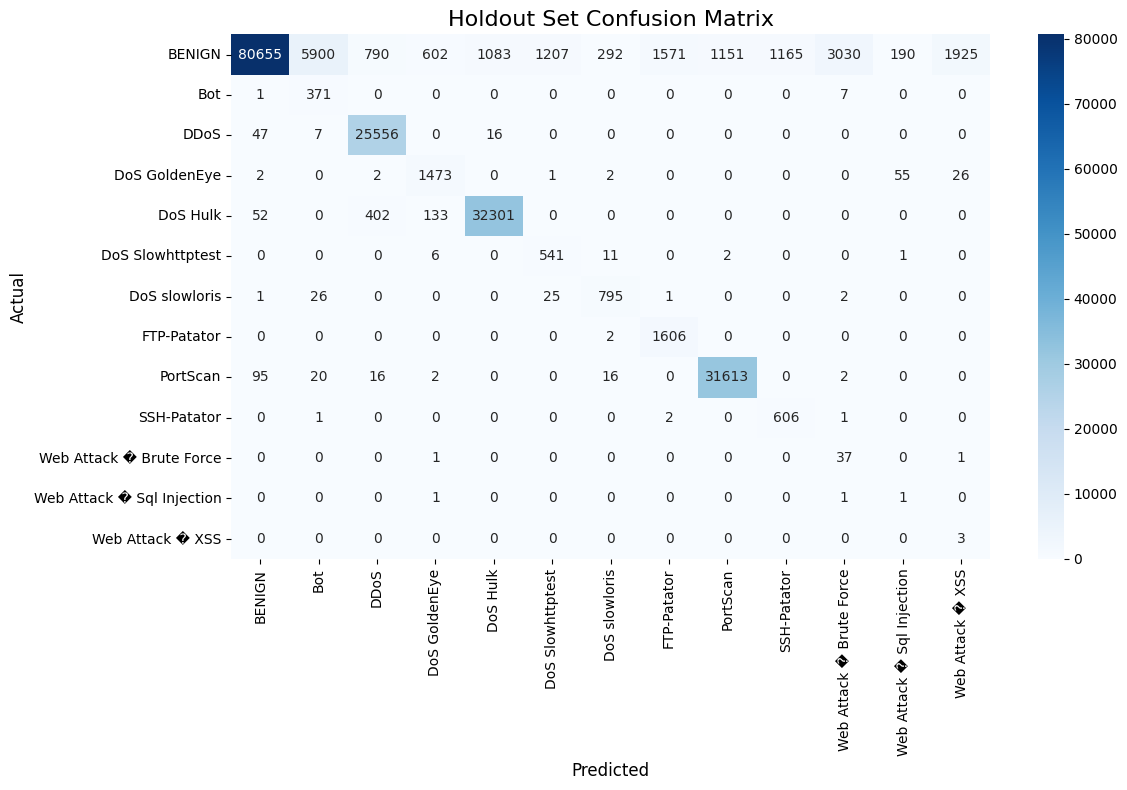

In [168]:
conf_matrix_holdout = confusion_matrix(y_holdout, y_holdout_pred)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(conf_matrix_holdout, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=ax)
plt.title("Holdout Set Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()

In [169]:
# Save the trained model
model.save('Internship Project/neural_network_model')
print("Neural network model saved to 'Internship Project/neural_network_model'")

INFO:tensorflow:Assets written to: Internship Project/neural_network_model\assets
Neural network model saved to 'Internship Project/neural_network_model'


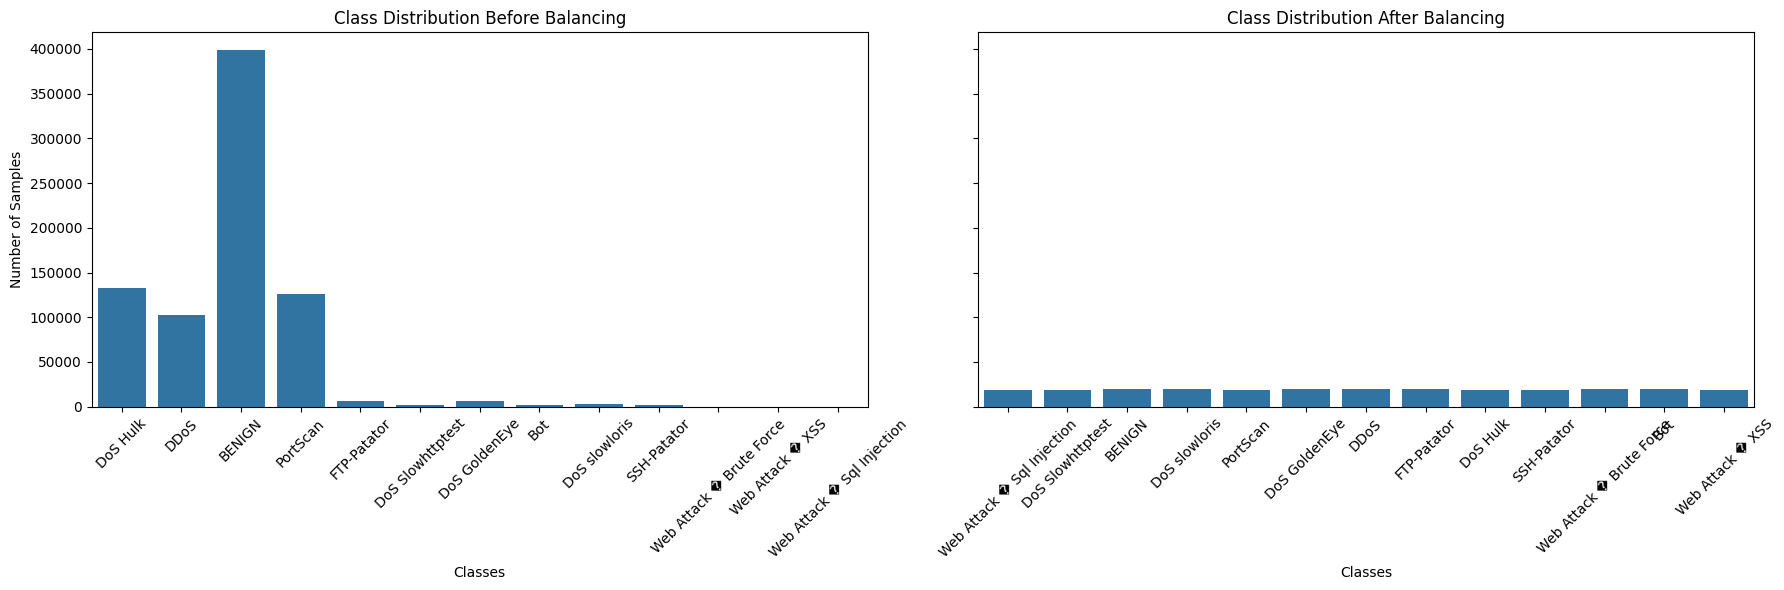

In [172]:
from collections import Counter

# Get the mapping of class labels to their names
class_names = {i: label for i, label in enumerate(label_encoder.classes_)}

# Class distribution before balancing
before_balancing = Counter(y_initial_train)
before_labels = [class_names[i] for i in before_balancing.keys()]
before_counts = list(before_balancing.values())

# Class distribution after balancing
after_balancing = Counter(y_resampled)
after_labels = [class_names[i] for i in after_balancing.keys()]
after_counts = list(after_balancing.values())

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Before balancing
sns.barplot(ax=axes[0], x=before_labels, y=before_counts)
axes[0].set_title("Class Distribution Before Balancing")
axes[0].set_xlabel("Classes")
axes[0].set_ylabel("Number of Samples")
axes[0].tick_params(axis='x', rotation=45)

# After balancing
sns.barplot(ax=axes[1], x=after_labels, y=after_counts)
axes[1].set_title("Class Distribution After Balancing")
axes[1].set_xlabel("Classes")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

